# Training Analysis (M1)

Given an output folder produced by `execute_m1.py`, this notebook will do 
the following: 
 - [x] Load the log files, parse the losses over time. 
 - [ ] Load the dataset with the proper parameters. 
	 - Use `data_format_args.pkl`.
 - [ ] Load the model from a particular checkpoint. 
	 - Use `instantiation_params.pkl`.
 - [ ] Run the model on some data, visualize the reconstructions it makes at each point in time. 
	 - Use `predictive_training_kwargs.pkl`.


In [3]:
## Which experiment do we want to analyze?
experiment_dir = "../training/debug/2022-10-28_04:37:48"

In [4]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math
import pickle

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio

## Loss Visualization over Time

In [14]:
# Get the stdout.log file, line by line. 
present_losses = []
future_losses = []
losses = []

stdo = open(os.path.join(experiment_dir, 'stdout.log'), 'r')

cnt = 0
for line in tqdm(stdo.readlines()):
	if line.startswith("Final loss:  "):
		loss_string = line.split(' ')[-1]
		loss = float(loss_string)
		losses.append(loss)
	elif line.startswith("Total surprise:"):
		loss_string = line.split(' ')[-1]
		present_loss = float(loss_string)
		present_losses.append(present_loss)
	elif line.startswith("Total future loss"):
		loss_string = line.split(' ')[-1]
		future_loss = float(loss_string)
		future_losses.append(future_loss)

present_losses = np.array(present_losses)
future_losses = np.array(future_losses)
losses = np.array(losses)


100%|██████████| 13584/13584 [00:00<00:00, 674520.83it/s]


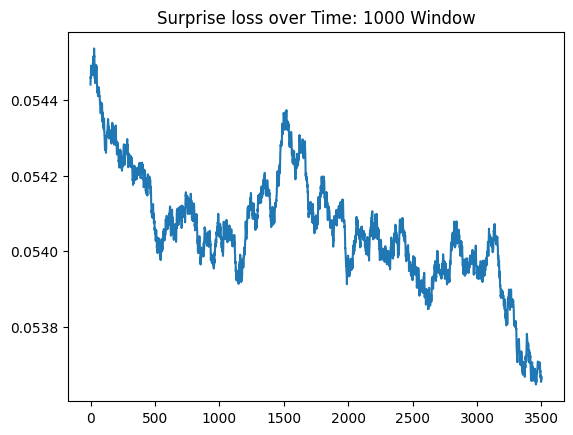

In [35]:
# plotting losses
def get_rolling_avg(ary_in, window=100):
	average_data = []
	for i in range(len(ary_in) - window + 1):
		average_data.append(np.mean(ary_in[i:i+window]))
	return np.array(average_data)

window_size=1000

plt.plot(get_rolling_avg(losses, window=window_size));
plt.title(f"Surprise loss over Time: {window_size} Window");

## Loading the Dataset

Formatting instructions found in `experiment_dir/data_format_args.pkl`.

In [37]:
# Read the pickle file
with open(os.path.join(experiment_dir, "data_format_args.pkl"), 'rb') as f: 
	data_format_args = pickle.load(f)

data_format_args

{'k_space': 15,
 'mu_space': 20,
 'k_time': 64,
 'mu_time': 200,
 'out_size': ['64', '64'],
 'patch_height': 4,
 'patch_width': 4,
 'patch_duration': 3}

In [66]:
k_space = data_format_args['k_space']
mu_space = data_format_args['mu_space']
k_time = data_format_args['k_time']
mu_time = data_format_args['mu_time']

out_size = [int(i) for i in data_format_args['out_size']]

patch_height = data_format_args['patch_height']
patch_width = data_format_args['patch_width']
patch_duration = data_format_args['patch_duration']

code_dim = 2*(2*k_space+1) + (2*k_time+1) # k_space = 15 and k_time = 64 -> 191

In [70]:
## Acquiring the dataset!
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp

# Meta/constants -- TODO: These should be commandline arguments. 
DATA_FOLDER = "../datasets/downloads"
num_frames = 100
output_size = out_size

# patch_height = 16
# patch_width = 16
# patch_duration = 3

batch_size = 1
num_prefetch = 4

# Fourier feature codes 
# k_space = 15
# mu_space = 20 
# k_time = 64 
# mu_time = 200

# Mp4 list: 
mp4_list = os.listdir(DATA_FOLDER)

## Acquiring the dataset!
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp

# Meta/constants -- TODO: These should be commandline arguments. 
DATA_FOLDER = "../datasets/downloads"
num_frames = 100
output_size = out_size

# patch_height = 16
# patch_width = 16
# patch_duration = 3

batch_size = 13
num_prefetch = 4

# Fourier feature codes 
# k_space = 15
# mu_space = 20 
# k_time = 64 
# mu_time = 200

# Mp4 list: 
mp4_list = os.listdir(DATA_FOLDER)

print("\n\n\n")
print("\t=========================")
print("\t=== DATASET META INFO ===")
print("\t=========================")
print("num_frames: ", num_frames)
print("batch_size: ", batch_size)
print("output_size: ", output_size)
print("Patch h/w/d: ", patch_height, patch_width, patch_duration)
print("k, mu for space, time: ", (k_space, mu_space), (k_time, mu_time))
print("mp4_list[:10] -- ", mp4_list[:10])


## Creating the generator
print("\n\n\n")
print("\t========================")
print("\t=== DATASET CREATION ===")
print("\t========================")
def generate_video_tensors():
	""" This is a generator for raw video tensors of shape 
	[num_frames, height, width, channels]. 

	It uses global variables defined above under "meta/constants". These 
	will be commandline arguments in the future. 
	"""
	_mp4_list = mp4_list
	_DATA_FOLDER = DATA_FOLDER
	_output_size = output_size
	_num_frames = num_frames
	while True: 
		for fname in _mp4_list:
			try:
				retval = vl.get_single_video_tensor(os.path.join(_DATA_FOLDER, fname), _num_frames, output_size=_output_size)
			except:
				continue
			if type(retval) == np.ndarray and retval.shape[0] == _num_frames:
				yield np.expand_dims(retval, axis=0)

videoset = tf.data.Dataset.from_generator(generate_video_tensors, output_signature=tf.TensorSpec(shape=[1, num_frames, *output_size, 3], dtype=tf.float32))
print(videoset)

def show_nn_sq(video_tensor, n=3, outname="breh.png"):
	n2 = n*n
	fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True)

	_nframes = video_tensor.shape[0]
	frame_inc = _nframes//(n2)

	for i in range(n):
		for j in range(n):
			full_idx = i*n + j

			axs[i,j].imshow(video_tensor[frame_inc*full_idx,:,:,:])
			axs[i,j].set_title(f"Frame {frame_inc*full_idx}")

	fig.suptitle(f"Video Survey over {_nframes} Frames")
	plt.savefig(outname)
	plt.show()

"""
out_test = "debug/test_from_videoset.png"
print(f"Showing off an element of the videodataset(generator) in `{out_test}`")	
for element in videoset:
	show_nn_sq(tf.squeeze(element), outname=out_test)
	break
"""

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(videoset, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=1)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=1)
FlatCodedPatchedSet = FlatCodedPatchedSet.map(lambda x: tf.squeeze(x))
FlatCodedPatchedSet = FlatCodedPatchedSet.batch(batch_size)
FlatCodedPatchedSet = FlatCodedPatchedSet.prefetch(num_prefetch)

cnt = 0
for el in FlatCodedPatchedSet: 
	print(" ** Shape of FlatCodedPatchedSet element: ", el.shape)
	cnt += 1
	if cnt == 2:
		break

print("Done getting datasets setup!")





	=== DATASET META INFO ===
num_frames:  100
batch_size:  13
output_size:  [64, 64]
Patch h/w/d:  4 4 3
k, mu for space, time:  (15, 20) (64, 200)
mp4_list[:10] --  ['H1iWETEMl7c.mp4', 'PmKbAgKa_V8.mp4', 'zymMiwUtbqE.mp4', 'jpeB76IUI9c.mp4', '5d-u6-UzbLk.mp4', 'm-EUUkPuocE.mp4', '_LUKHNsSndk.mp4', 'xp5sV_1SSKw.mp4', 'JXtr3GbDYHY.mp4', '3SeOIr2YisM.mp4']




	=== DATASET CREATION ===
<FlatMapDataset element_spec=TensorSpec(shape=(1, 100, 64, 64, 3), dtype=tf.float32, name=None)>
Making patches from Videoset...
Making the flat patch set...
Adding codes to the PatchSet...
Flattening the coded + patched dataset...
 ** Shape of FlatCodedPatchedSet element:  (13, 8448, 335)
 ** Shape of FlatCodedPatchedSet element:  (13, 8448, 335)
Done getting datasets setup!


In [71]:
## Visualizing a dataset element: 

## Instantiating the Model

In [72]:
import m1

In [73]:
# Read the pickle file
with open(os.path.join(experiment_dir, "instantiation_params.pkl"), 'rb') as f: 
	instantiation_params = pickle.load(f)

instantiation_params

{'encoder_args': [1],
 'encoder_kwargs': {'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'latent_ev_args': [1],
 'latent_ev_kwargs': {'distinct_blocks': False,
  'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'decoder_args': [144, 1, 0],
 'decoder_kwargs': {'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'perceiver_kwargs': {'code_dim': 191,
  'latent_dims': [700, 100],
  'p_droptoken': 0.5}}

In [74]:
## Setting up the component modules of the top-level PAE model.
# Encoder 

# Getting arguments 
encoder_args = instantiation_params['encoder_args']
encoder_kwargs = instantiation_params['encoder_kwargs']

test_encoder = m1.PAE_Encoder(*encoder_args, **encoder_kwargs)

# Latent evolver 
latent_ev_args = instantiation_params['latent_ev_args']
latent_ev_kwargs = instantiation_params['latent_ev_kwargs']

test_latent_ev = m1.PAE_Latent_Evolver(*latent_ev_args,**latent_ev_kwargs) 


# decoder
decoder_args = instantiation_params['decoder_args']
decoder_kwargs = instantiation_params['decoder_kwargs']

test_decoder = m1.PAE_Decoder(*decoder_args, **decoder_kwargs)

# Loss function definition
mse = tf.keras.losses.MeanSquaredError()

## Instantiating the PAE model!
perceiver_kwargs = instantiation_params['perceiver_kwargs']

perceiver_ae = m1.PerceiverAE(mse, test_encoder, test_latent_ev, test_decoder, **perceiver_kwargs)

## Getting Training Parameters

In [75]:
# Read the pickle file
with open(os.path.join(experiment_dir, "predictive_training_kwargs.pkl"), 'rb') as f: 
	training_kwargs = pickle.load(f)

training_kwargs

{'alpha': 0.7,
 'blind_iters': 1,
 'present_time_window': 5,
 'prediction_time_window': 30,
 'prob_prediction_select': 0.1,
 'window_increment': 5}

# Running the "Training loop"

In [76]:
perceiver_ae

In [77]:
training_kwargs
alpha = training_kwargs['alpha']
blind_iters = training_kwargs['blind_iters']
present_time_window = training_kwargs['present_time_window']
prediction_time_window = training_kwargs['prediction_time_window']
prob_prediction_select = training_kwargs['prob_prediction_select']
window_increment = training_kwargs['window_increment']

In [78]:
# get a batch tensor. 
batch_tensor = None
for ele in FlatCodedPatchedSet: 
	batch_tensor = ele 
	break

batch_tensor.shape

TensorShape([13, 8448, 335])

Text(0.5, 1.0, 'Video Tokens')

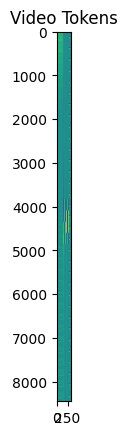

In [79]:
# Visualize the batch tensor
plt.imshow(batch_tensor[0,:,:])
plt.title("Video Tokens")

In [80]:
# Reconstruct the original
def get_source_video(flatpatched_coded):

	n_time_patches = num_frames // patch_duration
	n_height_patches = output_size[0] // patch_height 
	n_width_patches = output_size[1] // patch_width 

	x = flatpatched_coded

	x_patch = vp.unflatten_patched(x, n_time_patches, n_height_patches, n_width_patches)
	print("x_patch shape: ", x_patch.shape)
	print("p_dur, p_height, p_width: ", patch_duration, patch_height, patch_width)
	x_3dpatch = vp.make_3D_patches(x_patch, patch_duration, patch_height, patch_width)
	x_video = vp.get_vidtensor_from_8D(x_3dpatch)

	return x_video

source_vid = get_source_video(batch_tensor[:,:,:-code_dim])
source_vid.shape

x_patch shape:  (13, 33, 16, 16, 144)
p_dur, p_height, p_width:  3 4 4


TensorShape([13, 99, 64, 64, 3])

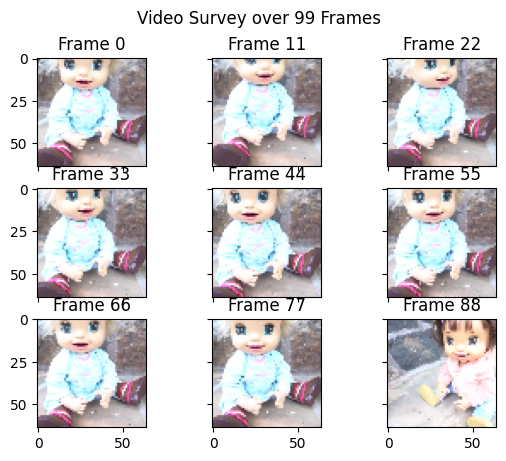

In [83]:
show_nn_sq(source_vid[1,:,:,:,:])

In [82]:

assert 0 <= alpha

num_tokens = batch_tensor.shape[1]

num_frames = round(num_tokens/tokens_per_frame)
window_inc_tokens = window_increment * tokens_per_frame
num_iters = round(num_tokens/window_inc_tokens)

window_inc_tokens = window_inc_tokens

present_window_tokens = round(present_time_window * tokens_per_frame)
future_window_tokens = round(prediction_time_window * tokens_per_frame)

"""
print("\nNUM TOKENS: ", num_tokens)
print("NUM FRAMES: ", num_frames)

print("Window increment (frames): ", window_increment)
print("Window increment (tokens): ", window_inc_tokens)

print("NUM ITERS: ", num_iters)
print("Future window tokens (pre-mask): ", future_window_tokens)
"""

future_msk = np.zeros(future_window_tokens, dtype=np.bool)
future_msk[:round(future_window_tokens*prob_prediction_select)] = True
np.random.shuffle(future_msk)

surprise_loss = 0.0 	# Corresponds to prediction of incoming data from the "present"
future_loss = 0.0		# Corresponds to prediction loss on far future data. 
loss = 0.0

with tf.GradientTape() as tape:
	for i in range(num_iters):
		# Calculating the present window.
		present_window_end = i*window_inc_tokens + present_window_tokens 
		present_window_end = round(present_window_end)
		if present_window_end > num_tokens:
			present_window_end = num_tokens
		window_start = present_window_end - present_window_tokens

		# Calculating the future window.
		future_window_end = window_start + future_window_tokens
		if future_window_end > num_tokens:
			future_window_end = num_tokens

		future_window_start = future_window_end - future_window_tokens
		# print(f"Iteration {i} of {num_iters}")
		# print(f"\tPRESENT WINDOW: [{window_start}, {present_window_end}] -- \t{present_window_end-window_start}")
		# print(f"\tFUTURE WINDOW: [{future_window_start}, {future_window_end}] -- \t{future_window_end - future_window_start}")

		## Extracting current windowed tensors 
		present = batch_tensor[:,window_start:present_window_end,:]
		future_ = batch_tensor[:,future_window_start:future_window_end,:]
		future = tf.boolean_mask(future_, future_msk, axis=1)

		np.random.shuffle(future_msk)

		# print("\tPresent Tensor Shape: ", present.shape)
		# print("\tFuture  Tensor Shape: ", future.shape)

		reset = i==0
		# pdb.set_trace()
		cur_surprise = model(present, reset_latent=reset)
		fut_surprise = model(future, remember_this=False, no_droptoken=True)
		if i >= blind_iters:
			surprise_loss += cur_surprise
			future_loss += fut_surprise		

		# print(f"\tCurrent loss: ", cur_surprise.numpy())
		# print(f"\tFuture loss: ", fut_surprise.numpy())

	surprise_loss /= num_iters
	future_loss /= num_iters

	loss = alpha*surprise_loss + (1-alpha)*future_loss


print("Total surprise: ", surprise_loss.numpy())
print("Total future loss: ", future_loss.numpy())

print("Final loss: ", loss.numpy())

grads = tape.gradient(loss, model.trainable_weights)
optimizer.apply_gradients(zip(grads, model.trainable_weights))

return surprise_loss, future_loss, loss

NameError: name 'tokens_per_frame' is not defined